In [9]:
import numpy as np
import pandas as pd
import itertools
import networkx as nx 
import matplotlib.pyplot as plt
import random
import itertools

Read csv into pandas dataframe

In [10]:
data = pd.read_csv('yncmods.csv')

## Conditions for being neighbours

When 2 modules cannot clash with each other, we connect them with an edge so they have to be assigned different colours. 

### Within each major:
1000 cannot clash with 1000 and 2000;

2000 cannot clash with 1000 and 2000;

3000 cannot clash with 3000 and 4000;

4000 cannot clash with 3000 and 4000;

Prof cannot be the same.

If the module code indicates that it is a class with other sessions, eg. "YSC1212-1", it is ok if it clashes with other 1000 and 2000 modules (except for itself, since the prof is the same), since there is more than one session for that module, and students just need to fit one session in their schedule if they want to take it.

In [11]:
dic = {}

for i in range(0, len(data.index)):
    # Add modules of the same level as values
    if (data["Level"][i] == 1000) & (len(data["Module Code"][i]) != 9): 
        dic[data["Module Code"][i]] = \
        data[(((data["Level"] == 1000) \
               & (data["Major"][i] == data["Major"])) \
              | ((data["Level"] == 2000) \
                 & (data["Major"][i] == data["Major"])) \
              | (data["Instructor"] == data["Instructor"][i])) \
             & (data["Module Code"] != data["Module Code"][i])]["Module Code"].tolist()
        
    elif (data["Level"][i] == 2000) & (len(data["Module Code"][i]) != 9):
        dic[data["Module Code"][i]] = \
        data[(((data["Level"] == 1000) \
               & (data["Major"][i] == data["Major"])) \
              | ((data["Level"] == 2000) \
                 & (data["Major"][i] == data["Major"])) \
              | (data["Instructor"] == data["Instructor"][i])) \
             & (data["Module Code"] != data["Module Code"][i])]["Module Code"].tolist()
        
    elif (data["Level"][i] == 3000) or ((data["Level"][i] == 4000) & (len(data["Module Code"][i]) != 9)): 
        dic[data["Module Code"][i]] = \
        data[(((data["Level"] == 3000) & (data["Major"][i] == data["Major"])) \
              | ((data["Level"] == 4000) & (data["Major"][i] == data["Major"])) \
             | (data["Instructor"] == data["Instructor"][i]))
             & (data["Module Code"] != data["Module Code"][i])]["Module Code"].tolist()
        
    elif (len(data["Module Code"][i]) == 9): 
        dic[data["Module Code"][i]] = data[(data["Instructor"] == data["Instructor"][i]) \
                                           & (data["Module Code"] != data["Module Code"][i])]["Module Code"].tolist()

## Coloring Algorithm

We adapted an algorithm from Wikipedia which works as such: 
1. The `first_available` function serves as a helper function that takes in a list of colors (with each color represented as an integer) and returns the smallest non-negative integer not in the given list. 
2. In the `greedy_color` function, we first initialise a dictionary which will store colors (represented as integers) as keys, and the nodes of that color as its values.  
3. We then added the additional dictionary `color_count` to store the colors as keys and the number of nodes with that color as its value - this allows us to later limit each colour to only have 29 modules, as we only have 29 classrooms.
4. For each node in the `order` that we had specified, we then use a for loop to perform the following: 
    1. Obtain a list of colors used by the neighbours of the node 
    2. Use our helper function `first_available` to determine the color of the current node
    3. We then increase the count of the color returned in `color_count` by 1. 
    4. If the `color_count` exceeds 29, this means that the current node cannot take on this color as there as not enough classrooms. We thus add this to the list of neighbour colors, and then use our helper function `first_available` again to find the color for our current node. 

In [12]:
def first_available(color_list):
    """Return smallest non-negative integer not in the given list of colors."""
    color_set = set(color_list)
    count = 0
    while True:
        if count not in color_set :
            return count
        count += 1
        
def greedy_color(G, order):
    """Find the greedy coloring of G in the given order.
    The representation of G is assumed to be like https://www.python.org/doc/essays/graphs/
    in allowing neighbors of a node/vertex to be iterated over by "for w in G[node]".
    The return value is a dictionary mapping vertices to their colors."""
    color = {}
    color_count = {}
    for node in order:
        used_neighbour_colors = [color[nbr] for nbr in G[node]
                                 if nbr in color]
        color[node] = first_available(used_neighbour_colors)
        
        used_color = color[node]
        
        if used_color in color_count:
            color_count[used_color] = color_count.get(used_color) + 1
        else :
            color_count.setdefault(color[node],0)
        
        while (color_count.get(used_color) > 28) : 
            used_neighbour_colors.append(used_color)
            color[node] = first_available(used_neighbour_colors)
            used_color = color[node]
            if used_color in color_count:
                color_count[used_color] = color_count.get(used_color) + 1
            else :
                color_count.setdefault(color[node],0)
            
    return color

We apply the algorithm to our modules, and find out the number of colours obtained by greedy algorithm

In [13]:
diclist = list(dic.keys())
coloring = greedy_color(dic, diclist)

colors_to_mod = {} 
for key in coloring:
    colors_to_mod.setdefault(coloring[key],[]).append(key)
    
print("The number of colours is", len(colors_to_mod))

count = 0

print("The number of modules in each colour: ")
for i in range(0, len(colors_to_mod)):
    print(len(colors_to_mod[i]))
    count = count + len(colors_to_mod[i])
    
print("The total number of modules is", count)

The number of colours is 10
The number of modules in each colour: 
29
29
29
19
14
10
6
3
2
1
The total number of modules is 142


We try it again with a different order of vertices.

In [14]:
diclist.reverse()
coloring = greedy_color(dic, diclist)

colors_to_mod = {} 
for key in coloring:
    colors_to_mod.setdefault(coloring[key],[]).append(key)
    
print("The number of colours is", len(colors_to_mod))

count = 0

print("The number of modules in each colour: ")
for i in range(0, len(colors_to_mod)):
    print(len(colors_to_mod[i]))
    count = count + len(colors_to_mod[i])
    
print("The total number of modules is", count)

The number of colours is 10
The number of modules in each colour: 
29
29
27
18
13
10
7
4
3
2
The total number of modules is 142


## Apply greedy algorithm on random permutations

We randomly shuffle the order of the vertices, to see what different colours we can get with the greedy algorithm.

In [15]:
def random_color(G,I):
    """
    RANDOM:
    Iterate the following process I times:
        Randomly permute the vertices;
        Apply Greedy algorithm;
        If the current coloring is the best one found, save it.
    Then report the best coloring found.
    """
    bestCount = 200000000
    worstCount = (-1)
    bestColoring = {}
    worstColoring = {}
    counts = []

    '''
    list_of_tuples = list(permutations(G.keys()))
    perm = [list(elem) for elem in list_of_tuples]
    
    for i in range(100):
        perm_pruned.append(perm[i])'''
   
    for i in range(I):
        ''' print(itertools.permutations(G.keys()))'''
        ''' random.shuffle(list(G.keys()))'''
        
        random_order = np.random.permutation(list(G.keys()))
        bestColoring = greedy_color(G,random_order)
        count = max(list(bestColoring.values())) + 1 
        counts.append(count)
        
        if count < bestCount:
            bestCount = count
            bestColoring = G
        if count > worstCount:
            worstCount = count
            worstColoring = G
    return counts, bestCount, worstCount

In [8]:
from collections import Counter 

counts, _ , _= random_color(dic, 1000000)

number_of_unique_values = len(Counter(counts).keys())

plt.hist(counts,bins = number_of_unique_values)
plt.show()

KeyboardInterrupt: 

We make a histogram to look at the frequencies of different colorings obtained. From the histogram, we can see that for 1000 different permutations, we only get 7. It is reasonable to conclude that the chromatic number is 7.

## Graph representation

We visualise the graph and obtain the information about the graph's cycles to see whether we can get any new insghts. 

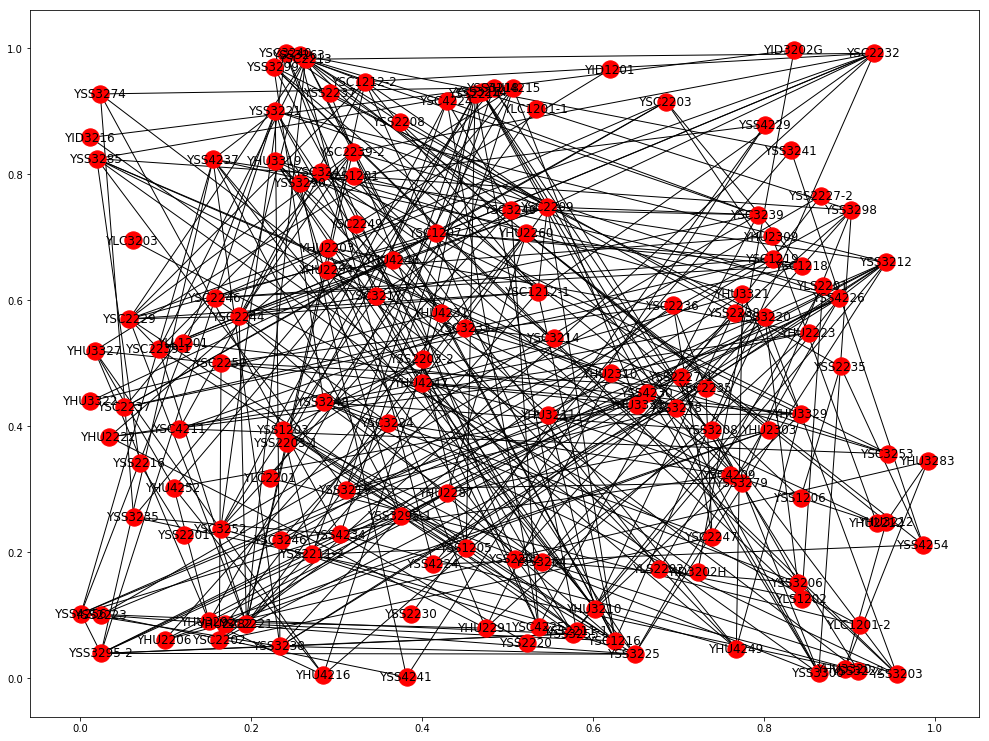

In [59]:
edges1 = []

for i in dic.keys():
    for j in dic[i]:
        edges1.append((i,j))

        
edges = []

for i in edges1: 
    if (i[1], i[0]) not in edges:
        edges.append(i)
        

G = nx.Graph() 
G.add_edges_from(edges) 
pos = nx.random_layout(G)
plt.figure(figsize =(17, 13)) 
nx.draw_networkx(G, pos, with_label = False)

In [63]:
cycles = nx.cycle_basis(G)

maxlen = 0
for i in cycles:
    if len(i) > maxlen: 
        maxlen = len(i)
        
minlen = 10
for i in cycles:
    if len(i) < minlen: 
        minlen = len(i)
        
print("The number of cycles is", len(cycles),"\n", "The longest cycle is", maxlen,"\n", "The shortest cycle is", minlen)

The number of cycles is 16 
 The longest cycle is 3 
 The shortest cycle is 3


## Visualisations of subgraphs of majors

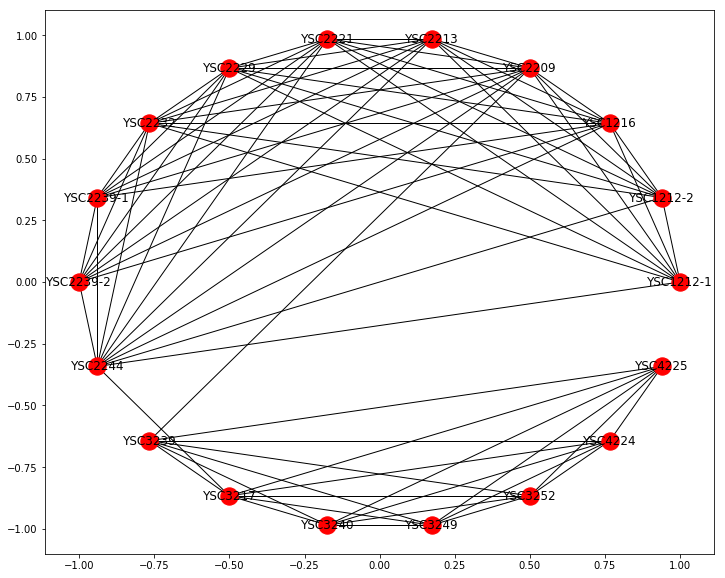

In [52]:
keys_mcs = []

for i in range(0, len(data.index)):
    if (data["Major"][i] == "MCS"): 
        keys_mcs.append(data["Module Code"][i])
        
edges_mcs = []

for i in keys_mcs:
    for j in dic[i]:
        edges_mcs.append((i,j))

G = nx.Graph() 
G.add_edges_from(edges_mcs) 
pos = nx.circular_layout(G)
plt.figure(figsize =(12, 10)) 
nx.draw_networkx(G, pos, with_label = False)

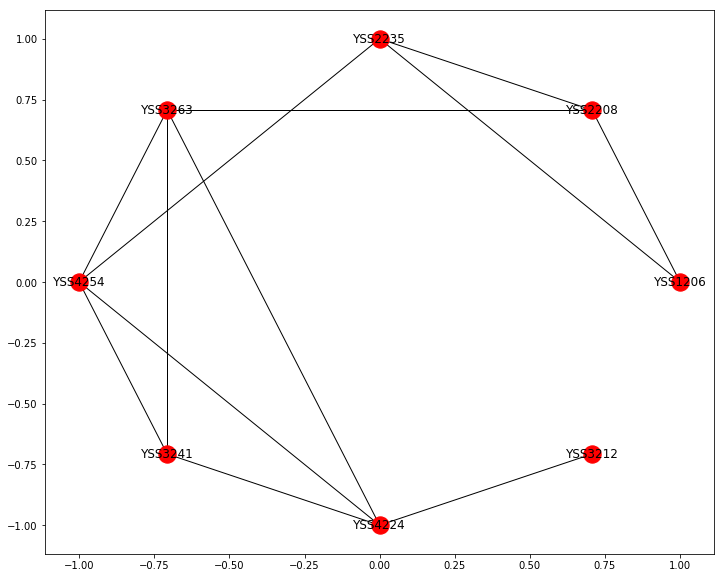

In [54]:
keys_ppe = []

for i in range(0, len(data.index)):
    if (data["Major"][i] == "PPE"): 
        keys_ppe.append(data["Module Code"][i])
        
edges_ppe = []

for i in keys_ppe:
    for j in dic[i]:
        edges_ppe.append((i,j))

G = nx.Graph() 
G.add_edges_from(edges_ppe) 
pos = nx.circular_layout(G)
plt.figure(figsize =(12, 10)) 
nx.draw_networkx(G, pos, with_label = False)

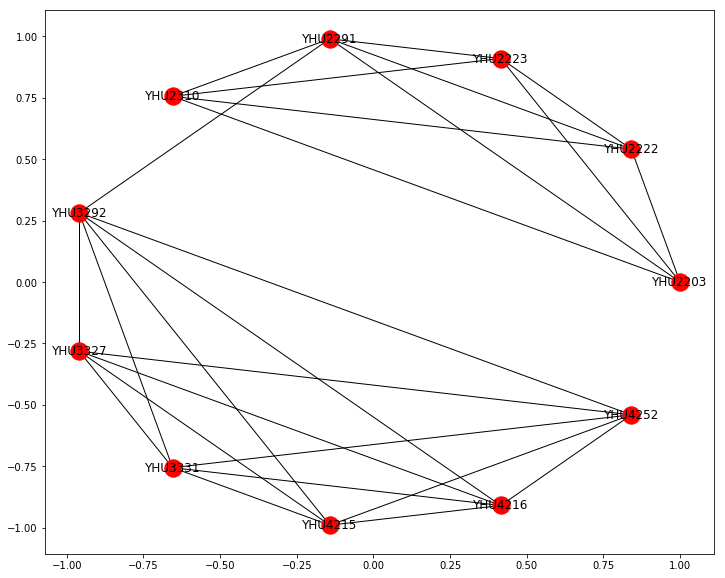

In [61]:
keys_AH = []

for i in range(0, len(data.index)):
    if (data["Major"][i] == "ARTS HUM"): 
        keys_AH.append(data["Module Code"][i])
        
edges_AH = []

for i in keys_AH:
    for j in dic[i]:
        edges_AH.append((i,j))

G = nx.Graph() 
G.add_edges_from(edges_AH) 
pos = nx.circular_layout(G)
plt.figure(figsize =(12, 10)) 
nx.draw_networkx(G, pos, with_label = False)

## With CC Mods


In [29]:
data_cc = pd.read_csv('yncmods2_distinct.csv')

In [30]:
len(data_cc.index)

188

In [31]:
dic_cc = {}

for i in range(0, len(data_cc.index)):
    # For CC Mods
    # if it is not the same CC mod and in the same AM/PM session
    # or if the mods have the same instructor 
    if ((data_cc["Level"][i] == 1000) & (data_cc["Major"][i] == "CC")): 
        dic_cc[data_cc["Module Code"][i]] = \
        data_cc[(((data_cc["Module Code"][i][:9] != data_cc["Module Code"].str[:9]) \
                  & (data_cc["Major"] == "CC")\
                | (data_cc["Instructor"] == data_cc["Instructor"][i])) \
                 & (data_cc["Module Code"] != data_cc["Module Code"][i]))]["Module Code"].tolist()

    # Add modules of the same level as values
    elif (data_cc["Level"][i] == 1000) & (len(data_cc["Module Code"][i]) != 9): 
        dic_cc[data_cc["Module Code"][i]] = \
        data_cc[(((data_cc["Level"] == 1000) \
               & (data_cc["Major"][i] == data_cc["Major"])) \
              | ((data_cc["Level"] == 2000) \
                 & (data_cc["Major"][i] == data_cc["Major"])) \
              | (data_cc["Instructor"] == data_cc["Instructor"][i])) \
             & (data_cc["Module Code"] != data_cc["Module Code"][i])]["Module Code"].tolist()
        
    elif (data_cc["Level"][i] == 2000) & (len(data_cc["Module Code"][i]) != 9):
        dic_cc[data_cc["Module Code"][i]] = \
        data_cc[(((data_cc["Level"] == 1000) \
               & (data_cc["Major"][i] == data_cc["Major"])) \
              | ((data_cc["Level"] == 2000) \
                 & (data_cc["Major"][i] == data_cc["Major"])) \
              | (data_cc["Instructor"] == data_cc["Instructor"][i])) \
             & (data_cc["Module Code"] != data_cc["Module Code"][i])]["Module Code"].tolist()
        
    elif (data_cc["Level"][i] == 3000) | ((data_cc["Level"][i] == 4000) & (len(data_cc["Module Code"][i]) != 9)): 
        dic_cc[data_cc["Module Code"][i]] = \
        data_cc[(((data_cc["Level"] == 3000) & (data_cc["Major"][i] == data_cc["Major"])) \
              | ((data_cc["Level"] == 4000) & (data_cc["Major"][i] == data_cc["Major"])) \
             | (data_cc["Instructor"] == data_cc["Instructor"][i]))
             & (data_cc["Module Code"] != data_cc["Module Code"][i])]["Module Code"].tolist()
        
    elif (len(data_cc["Module Code"][i]) == 9): 
        dic_cc[data_cc["Module Code"][i]] = data_cc[(data_cc["Instructor"] == data_cc["Instructor"][i]) \
                                           & (data_cc["Module Code"] != data_cc["Module Code"][i])]["Module Code"].tolist()
   

In [32]:
len(dic_cc.keys())

188

In [33]:
dic_cc

{'YCC1131-L': ['YCC1131-1-1',
  'YCC1131-1-2',
  'YCC1131-1-3',
  'YCC1131-1-4',
  'YCC1131-1-5',
  'YCC1131-1-6',
  'YCC1131-1-7',
  'YCC1131-2-1',
  'YCC1131-2-2',
  'YCC1131-2-3',
  'YCC1131-2-4',
  'YCC1131-2-5',
  'YCC1131-2-6',
  'YCC1131-2-7',
  'YCC1114-L',
  'YCC1114-1-1',
  'YCC1114-1-2',
  'YCC1114-1-3',
  'YCC1114-1-4',
  'YCC1114-1-5',
  'YCC1114-1-6',
  'YCC1114-1-7',
  'YCC1114-2-1',
  'YCC1114-2-2',
  'YCC1114-2-3',
  'YCC1114-2-4',
  'YCC1114-2-5',
  'YCC1114-2-6',
  'YCC1114-2-7',
  'YCC1112-L',
  'YCC1112-1-1',
  'YCC1112-1-2',
  'YCC1112-1-3',
  'YCC1112-1-4',
  'YCC1112-2-1',
  'YCC1112-1-5',
  'YCC1112-2-2',
  'YCC1112-1-6',
  'YCC1112-2-3',
  'YCC1112-1-7',
  'YCC1112-2-4',
  'YCC1112-2-5',
  'YCC1112-2-6',
  'YCC1112-2-7'],
 'YCC1131-1-1': ['YCC1131-L',
  'YCC1131-2-1',
  'YCC1131-2-2',
  'YCC1131-2-3',
  'YCC1131-2-4',
  'YCC1131-2-5',
  'YCC1131-2-6',
  'YCC1131-2-7',
  'YCC1114-L',
  'YCC1114-1-1',
  'YCC1114-1-2',
  'YCC1114-1-3',
  'YCC1114-1-4',
  'YCC1114

In [34]:
diclist_cc = list(dic_cc.keys())
coloring_cc = greedy_color(dic_cc, diclist_cc)

colors_to_mod_cc = {} 
for key in coloring_cc:
    colors_to_mod_cc.setdefault(coloring_cc[key],[]).append(key)
    
print("The number of colours is", len(colors_to_mod_cc))

count_cc = 0

print("The number of modules in each colour: ")
for i in range(0, len(colors_to_mod_cc)):
    print(len(colors_to_mod_cc[i]))
    count_cc = count_cc + len(colors_to_mod_cc[i])

print("The total number of modules is ", count_cc)

The number of colours is 10
The number of modules in each colour: 
29
29
29
25
26
18
9
11
10
2
The total number of modules is  188


In [35]:
colors_to_mod_cc[9]

['YSS4256', 'YSS4230']

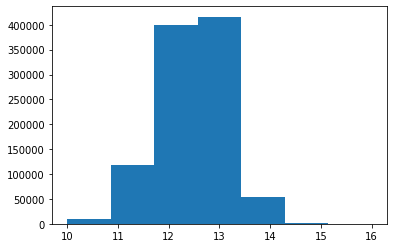

In [101]:
counts, _ , _= random_color(dic_cc, 1000000)

number_of_unique_values = len(Counter(counts).keys())

plt.hist(counts,bins = number_of_unique_values)
plt.show()